# Customer related Analysis for our data

### In this hypothesis we are going to answer below questions:
1. Who are your best customers? 
2. Which of your customers could contribute to your churn rate?  
3. Who has the potential to become valuable customers?  
4. Which of your customers can be retained?  
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import squarify
import plotly.express as px


In [2]:
df=pd.read_csv("C:/Users/vipulchopra/EDA/Supermart_Dataset.csv")
df.head()

,Order ID,Customer Name,Customer Id,Age,Gender,Category,Sub Category,Region,State,City,Order Date,Time,Payment Method,Sales,Quantity,Discount,Profit,Rating
0,OD1,Harish,13,53,Male,Oil & Masala,Masalas,North,Tamil Nadu,Vellore,2017-11-08,13:03:25,Cash,1254,7,0.12,401.28,8.0
1,OD2,Sudha,38,31,Female,Beverages,Health Drinks,South,Tamil Nadu,Krishnagiri,2017-11-08,12:09:46,Cash,749,14,0.18,149.80,1.0
2,OD3,Hussain,15,18,Male,Food Grains,Atta & Flour,West,Tamil Nadu,Perambalur,2017-06-12,14:14:10,Credit card,2360,22,0.21,165.20,1.0
3,OD4,Jackson,16,69,Male,Fruits & Veggies,Fresh Vegetables,South,Tamil Nadu,Dharmapuri,2016-10-11,09:22:01,Cash,896,13,0.25,89.60,8.0
4,OD5,Ridhesh,29,12,Male,Food Grains,Organic Staples,South,Tamil Nadu,Ooty,2016-10-11,17:01:25,Ewallet,2355,8,0.26,918.45,9.0


### Defining the RFM terminologies as:
1. The more recent they purchase, the more responsive the customers are i.e recent purchase = low recency value.
2. The more frequently the customers buy, the more engaged and satisfied they are i.e high frequency = high f value.
3. The more they spend, the higher their monetary value.

In [3]:
df['Unit Sale Price']=round(df['Sales']/df['Quantity'],2)
df["Order Date"]=pd.to_datetime(df["Order Date"])

### Calculating the Recency , considering the last date of "Order Date" as reference

In [4]:
Recency = pd.DataFrame(df.groupby('Customer Id')['Order Date'].max().reset_index())
Recency['Recency'] = (Recency['Order Date'].max() - Recency['Order Date']).dt.days + 1
Recency.head()

,Customer Id,Order Date,Recency
0,1,2018-12-23,8
1,2,2018-12-29,2
2,3,2018-12-28,3
3,4,2018-12-24,7
4,5,2018-12-27,4


### Calculating the Frequency for every Customer Id

In [5]:
Frequency = pd.DataFrame(df.groupby('Customer Id')['Order ID'].nunique(). reset_index())
Frequency.columns= ['fCustomer Id', 'Frequency']
Frequency.head()

,fCustomer Id,Frequency
0,1,205
1,2,187
2,3,196
3,4,198
4,5,227


### Calculating the MonetaryValue , by considering the profit received by a customer in the whole data tenure

In [6]:
MonetaryValue = pd.DataFrame(df.groupby('Customer Id')['Profit'].sum(). reset_index())
MonetaryValue.columns= ['mCustomer Id', 'MonetaryValue']
MonetaryValue.head()

,mCustomer Id,MonetaryValue
0,1,78044.29
1,2,78439.05
2,3,82121.26
3,4,74410.23
4,5,80191.89


### Concating the Recency,Frequency, MonetaryValue for unique Customer

In [7]:
rfm = pd.concat([Recency, Frequency, MonetaryValue], axis=1)
rfm.drop(['fCustomer Id', 'mCustomer Id','Order Date'], axis=1, inplace= True)
rfm.head()

,Customer Id,Recency,Frequency,MonetaryValue
0,1,8,205,78044.29
1,2,2,187,78439.05
2,3,3,196,82121.26
3,4,7,198,74410.23
4,5,4,227,80191.89


### Visualization of RFM data per Customer Id

<AxesSubplot:xlabel='Customer Id', ylabel='Recency'>

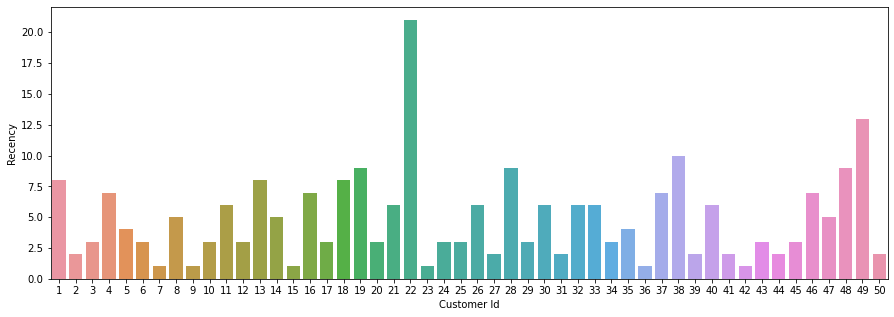

In [8]:
plt.figure(figsize=(15.0,5.0))
sns.barplot(data=rfm,x='Customer Id',y='Recency')

<AxesSubplot:xlabel='Customer Id', ylabel='Frequency'>

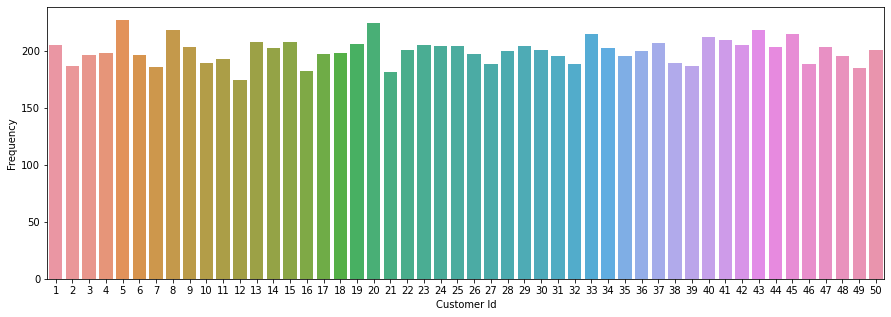

In [9]:
plt.figure(figsize=(15.0,5.0))
sns.barplot(data=rfm,x='Customer Id',y='Frequency')

<AxesSubplot:xlabel='Customer Id', ylabel='MonetaryValue'>

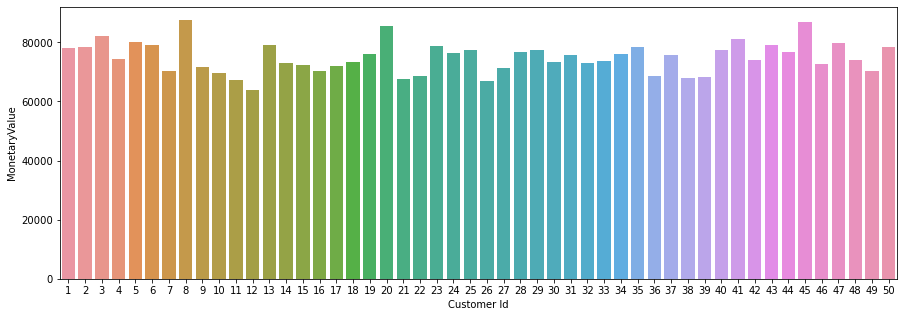

In [10]:
plt.figure(figsize=(15.0,5.0))
sns.barplot(data=rfm,x='Customer Id',y='MonetaryValue')


### Ranking the Data, segmenting the data into 4 groups from 1 to 4

In [11]:
r_labels = range(4, 0, -1);
f_labels = range(1, 5);
m_labels = range(1, 5)

r_groups = pd.qcut(rfm['Recency'].rank(method='first'), q=4, labels=r_labels)
f_groups = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels)
m_groups = pd.qcut(rfm['MonetaryValue'].rank(method='first'), q=4, labels=m_labels)

# Create new columns for R.F.M
rfm_seg = rfm.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)

# concatenate RFM quartile values
rfm_seg['RfmSegment'] = rfm_seg['R'].astype(str) + rfm_seg['F'].astype(str) + rfm_seg['M'].astype(str)

### Categorization of labels are as below:
1. **Champions** : Bought recently, buy often and spend the most!
2. **Loyal Customers** : Spend good money with us often.
3. **Potential Loyalist** : Recent customers, but spent a good amount and bought more than once.
4. **Recent Customers** : Bought most recently, but not often.
5. **Promising** : Recent shoppers, but haven’t spent much.
6. **Customers Needing Attention** : Above average recency, frequency and monetary values.
7. **Can’t Lose Them** : Made biggest purchases, and often. But haven’t returned for a long time. Need to bring them back!
8. **Hibernating** : Last purchase was long back, low spenders and bought seldomly. Will lose them if not reactivated.
9. **Lost** : Lowest recency, frequency and monetary scores (RFM score).

In [12]:
# define users rfm category, using the RfmSegment column
# logic is defined by business usually but here taking randomly
def users_cat(seg):
      if seg['RfmSegment'] == '444':
        return 'Champions'

      elif seg['RfmSegment'] == '111':
        return 'Lost'

      else:
        if seg['M'] == 4 & seg['F'] == 4: 
              return 'Loyal Customers'

        if  seg['M'] == 4 & seg['F'] >= 3 & seg['R'] == 1:
              return 'Cant Lose Them'

        if seg['R'] >= 3 & seg['F'] <= 2:
              return 'Recent Customers'

        if seg['R'] >= 3 & seg['M'] <= 2:
              return 'Promising'

        if seg['R'] >= 3 & seg['M'] >= 3 & seg['F'] >= 1 | seg['F'] <= 2:
              return 'Potential Loyalist'

        if seg['R'] >=2 & seg['M'] >= 2 & seg['F'] >= 2:
              return 'Customers Needing Attention'

        return 'Hibernating'

rfm_seg['RfmCat'] = rfm_seg.apply(users_cat, axis=1)
rfm_seg.sample(5)

,Customer Id,Recency,Frequency,MonetaryValue,R,F,M,RfmSegment,RfmCat
1,2,2,187,78439.05,4,1,4,414,Recent Customers
11,12,3,174,64037.35,3,1,1,311,Recent Customers
18,19,9,206,76165.17,1,4,3,143,Recent Customers
40,41,2,209,80996.85,4,4,4,444,Champions
25,26,6,197,66970.60,2,2,1,221,Recent Customers


In [13]:
# calculate the recency, frequency and monetary value mean, to see each category contribution
rfm_agg = rfm_seg.groupby(['RfmCat']).agg({'Recency': 'mean',
                                            'Frequency': 'mean',
                                            'MonetaryValue': ['mean', 'count']}).round(0)
rfm_agg.columns = rfm_agg.columns.droplevel()

rfm_agg.columns =['Recency mean', 'Frequency mean', 'MonetaryValue mean', 'counts']
rfm_agg['Percent'] = round((rfm_agg['counts']/ rfm_agg.counts.sum()) *100, 2)
rfm_agg = rfm_agg.reset_index()
rfm_agg

,RfmCat,Recency mean,Frequency mean,MonetaryValue mean,counts,Percent
0,Champions,2.0,209.0,80997.0,1,2.0
1,Customers Needing Attention,3.0,203.0,76809.0,5,10.0
2,Hibernating,8.0,199.0,75339.0,5,10.0
3,Lost,10.0,185.0,69526.0,3,6.0
4,Loyal Customers,4.0,218.0,83055.0,6,12.0
5,Promising,6.0,202.0,74864.0,7,14.0
6,Recent Customers,4.0,195.0,72801.0,23,46.0


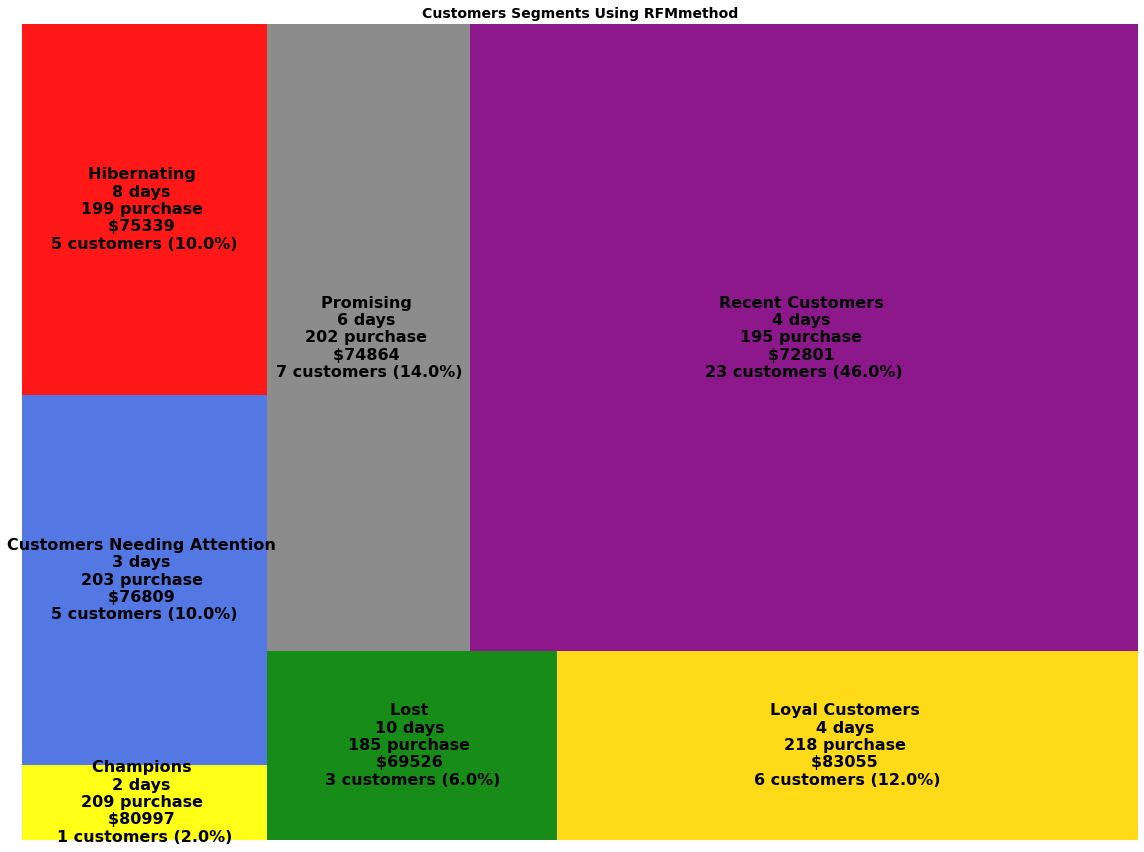

In [14]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 15)

colors_dict = {'Hibernating':'yellow','Promising':'royalblue',
               'Lost':'red', 'Champions':'green', 'Loyal Customers':'gold', 'Customers Needing Attention':'grey', 'Recent Customers': 'purple'}

squarify.plot(sizes = rfm_agg['counts'],
              text_kwargs = {'fontsize':16,'weight':'bold', 'fontname':'sans serif'},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} purchase \n${:.0f} \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.9 )


plt.title('Customers Segments Using RFMmethod', fontsize=14, fontweight = 'bold')
plt.axis('off')
plt.show()

In [15]:
#Profit value mean per per category

rfm_agg['Profit_per_category']=round(rfm_agg['MonetaryValue mean']/(rfm_agg['Recency mean']*rfm_agg['Frequency mean']))#rfm_agg['counts'])
rfm_agg

,RfmCat,Recency mean,Frequency mean,MonetaryValue mean,counts,Percent,Profit_per_category
0,Champions,2.0,209.0,80997.0,1,2.0,194.0
1,Customers Needing Attention,3.0,203.0,76809.0,5,10.0,126.0
2,Hibernating,8.0,199.0,75339.0,5,10.0,47.0
3,Lost,10.0,185.0,69526.0,3,6.0,38.0
4,Loyal Customers,4.0,218.0,83055.0,6,12.0,95.0
5,Promising,6.0,202.0,74864.0,7,14.0,62.0
6,Recent Customers,4.0,195.0,72801.0,23,46.0,93.0


### Checking a business Scenario, whether is it profitable to move a lower segment customer into higher segment?

In [81]:
#Considering the cost to convert  the same is per customer is 500.
#taking conversion ratio as 20%
category=["Champions","Loyal Customers","Recent Customers","Promising","Customers Needing Attention","Hibernating","Lost"]
t=[]
for i in range(1,len(category)):
    for j in range(i):
        t.append([category[i],category[j]])
t

[['Loyal Customers', 'Champions'],
 ['Recent Customers', 'Champions'],
 ['Recent Customers', 'Loyal Customers'],
 ['Promising', 'Champions'],
 ['Promising', 'Loyal Customers'],
 ['Promising', 'Recent Customers'],
 ['Customers Needing Attention', 'Champions'],
 ['Customers Needing Attention', 'Loyal Customers'],
 ['Customers Needing Attention', 'Recent Customers'],
 ['Customers Needing Attention', 'Promising'],
 ['Hibernating', 'Champions'],
 ['Hibernating', 'Loyal Customers'],
 ['Hibernating', 'Recent Customers'],
 ['Hibernating', 'Promising'],
 ['Hibernating', 'Customers Needing Attention'],
 ['Lost', 'Champions'],
 ['Lost', 'Loyal Customers'],
 ['Lost', 'Recent Customers'],
 ['Lost', 'Promising'],
 ['Lost', 'Customers Needing Attention'],
 ['Lost', 'Hibernating']]

In [82]:
Net_Profit=[]
for i in t:
    profit_conversion=list(rfm_agg[rfm_agg['RfmCat']==i[1]]['MonetaryValue mean'])[0]-list(rfm_agg[rfm_agg['RfmCat']==i[0]]['MonetaryValue mean'])[0]
    Net_Profit.append(profit_conversion*0.2*list(rfm_agg[rfm_agg['RfmCat']==i[0]]['counts'])[0]-500*list(rfm_agg[rfm_agg['RfmCat']==i[0]]['counts'])[0])
Net_Profit
    

[-5469.6,
 26201.6,
 35668.4,
 5086.200000000001,
 7967.4,
 -6388.200000000001,
 1688.0,
 3746.0,
 -6508.0,
 -4445.0,
 3158.000000000001,
 5216.0,
 -5038.0,
 -2975.0,
 -1030.0,
 5382.6,
 6617.400000000001,
 465.0,
 1702.8000000000002,
 2869.8,
 1987.8000000000002]

In [83]:
total=[]
for i in range(len(t)):
    t[i].append(Net_Profit[i])
    total.append(t[i])
x=pd.DataFrame(total,columns=["From","To","Profit"])
x

,From,To,Profit
0,Loyal Customers,Champions,-5469.6
1,Recent Customers,Champions,26201.6
2,Recent Customers,Loyal Customers,35668.4
3,Promising,Champions,5086.2
4,Promising,Loyal Customers,7967.4
5,Promising,Recent Customers,-6388.2
6,Customers Needing Attention,Champions,1688.0
7,Customers Needing Attention,Loyal Customers,3746.0
8,Customers Needing Attention,Recent Customers,-6508.0
9,Customers Needing Attention,Promising,-4445.0


In [84]:
def even_number_background(cell_value):
    highlight = 'background-color: #7FFFD4;' 
    
    default = 'background-color: #FA8072;'  
    if type(cell_value) in [float]:  
        if cell_value > 0:     
            return highlight  
        else:
            
            return default
x.style.applymap(even_number_background)



,From,To,Profit
0,Loyal Customers,Champions,-5469.600000
1,Recent Customers,Champions,26201.600000
2,Recent Customers,Loyal Customers,35668.400000
3,Promising,Champions,5086.200000
4,Promising,Loyal Customers,7967.400000
5,Promising,Recent Customers,-6388.200000
6,Customers Needing Attention,Champions,1688.000000
7,Customers Needing Attention,Loyal Customers,3746.000000
8,Customers Needing Attention,Recent Customers,-6508.000000
9,Customers Needing Attention,Promising,-4445.000000


In [85]:
Profit=[]
Loss=[]
for i in range(len(t)):
    if Net_Profit[i]>0:
        #t[i].append(Net_Profit[i])
        Profit.append(t[i])
    else:
        #t[i].append(Net_Profit[i])
        Loss.append(t[i])

In [86]:
profit=pd.DataFrame(Profit,columns=["From","To","Profit"])
profit

,From,To,Profit
0,Recent Customers,Champions,26201.6
1,Recent Customers,Loyal Customers,35668.4
2,Promising,Champions,5086.2
3,Promising,Loyal Customers,7967.4
4,Customers Needing Attention,Champions,1688.0
5,Customers Needing Attention,Loyal Customers,3746.0
6,Hibernating,Champions,3158.0
7,Hibernating,Loyal Customers,5216.0
8,Lost,Champions,5382.6
9,Lost,Loyal Customers,6617.4


In [87]:
loss=pd.DataFrame(Loss,columns=["From","To","Profit"])
loss

,From,To,Profit
0,Loyal Customers,Champions,-5469.6
1,Promising,Recent Customers,-6388.2
2,Customers Needing Attention,Recent Customers,-6508.0
3,Customers Needing Attention,Promising,-4445.0
4,Hibernating,Recent Customers,-5038.0
5,Hibernating,Promising,-2975.0
6,Hibernating,Customers Needing Attention,-1030.0
